In [1]:
%matplotlib inline

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

The current HDDM version is:  1.0.1RC
The current kabuki version is:  0.6.5RC4
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.15.1


In [2]:
dataset = hddm.load_csv('/home/jovyan/work/Desktop/Coding/HDDM/Python Prep Dataset/merged_pd.csv', skiprows=0,dtype={'age': 'str'})
dataset.head(5)

,subj_idx,rt,response,BlockType,StimType,TargetType,Block,Stim_cog_emo,gender,age,...,panic_s,sepanx_s,socphobia_s,scaared_total,gad_s,panic_c,sepanx_c,socphobia_c,gad_c,anxiety
0,11684,1.340,1.0,0-Back,NegFace,nonlure,3,Emo,2,18,...,16,0,11,46.0,21,1,0,1,1,1
1,11684,1.835,1.0,0-Back,NegFace,nonlure,4,Emo,2,18,...,16,0,11,46.0,21,1,0,1,1,1
2,11684,1.544,1.0,0-Back,NegFace,target,5,Emo,2,18,...,16,0,11,46.0,21,1,0,1,1,1
3,11684,1.167,1.0,0-Back,NegFace,lure,6,Emo,2,18,...,16,0,11,46.0,21,1,0,1,1,1
4,11684,0.999,1.0,0-Back,NegFace,nonlure,7,Emo,2,18,...,16,0,11,46.0,21,1,0,1,1,1


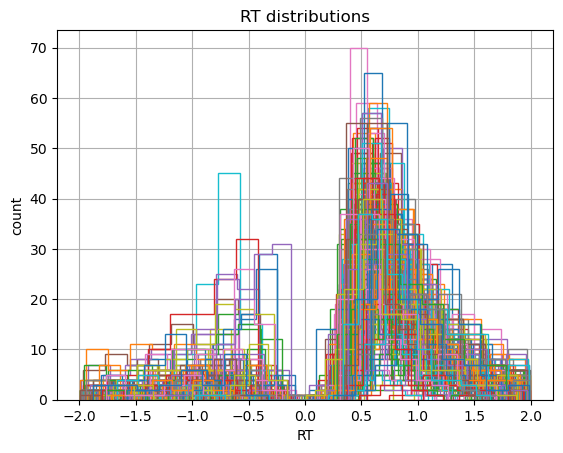

In [3]:
data = hddm.utils.flip_errors(dataset)
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

plt.savefig('hddm_demo_fig_00.pdf')

# Setting

In [4]:
# **Define Model and Sampling Settings **
model0_settings = {
    "include": ['a','v','t'],
    "informative": False,
    "is_group_model": True,
    "p_outlier": 0.05
}

model1_settings = {
    "include": ['a','v','t'],
    "informative": False,
    "is_group_model": True,
    "depends_on": {'a': ['Stim_cog_emo'],
                   'v': ['Stim_cog_emo'],
                   't': ['Stim_cog_emo'],
                  },
    "p_outlier": 0.05
}

model2_settings = {
    "include": ['a','v','t'],
    "informative": False,
    "is_group_model": True,
    "depends_on": {'a': ['StimType'],
                   'v': ['StimType'],
                   't': ['StimType'],
                  },
    "p_outlier": 0.05
}


model0_1_settings = {
    "include": ['a','v','t'],
    "informative": False,
    "is_group_model": True,
    "depends_on": {'a': ['BlockType'],
                   'v': ['BlockType'],
                   't': ['BlockType'],
                  },
    "p_outlier": 0.05
}

model1_1_settings = {
    "include": ['a','v','t'],
    "informative": False,
    "is_group_model": True,
    "depends_on": {'a': ['Stim_cog_emo','BlockType'],
                   'v': ['Stim_cog_emo','BlockType'],
                   't': ['Stim_cog_emo','BlockType'],
                  },
    "p_outlier": 0.05
}

model2_2_settings = {
    "include": ['a','v','t'],
    "informative": False,
    "is_group_model": True,
    "depends_on": {'a': ['StimType','BlockType'],
                   'v': ['StimType','BlockType'],
                   't': ['StimType','BlockType'],
                  },
    "p_outlier": 0.05
}


In [5]:
# Split the dataset into two based on anxiety status
dataset_anx1 = dataset[dataset['anxiety'] == 1].copy()  # Anxiety group
dataset_anx0 = dataset[dataset['anxiety'] == 0].copy()  # Non-Anxiety group

# Model Loading and Group Level Parameters

In [6]:

# Define models and settings
models_2 = {
    "model0_1": model0_1_settings,
    "model1_1": model1_1_settings,
    "model2_2": model2_2_settings
}

# Initialize dictionary to store models
loaded_models = {}

# Loop through each model for loading with anxiety0 and anxiety1
for anxiety_status in ["anx0", "anx1"]:
    for model_name in models_2.keys():
        try:
            # Define model variable name with anxiety state
            model_var_name = f"{model_name}_{anxiety_status}"
            nc_name = f"{model_var_name}_infdata.nc"

            # Load HDDM model
            model_file = f"{model_var_name}"  # Adjust if different
            loaded_model = hddm.load(model_file)
            print(f"HDDM Model Loaded: {model_var_name}")

            # Load inference data
            infdata = az.from_netcdf(nc_name)
            print(f"Inference Data Loaded: {nc_name}")

            # Extract all variable names
            all_vars = list(infdata.posterior.data_vars)

            # Filter out variables containing "subj"
            filtered_vars = [var for var in all_vars if "subj" not in var]

            # Generate summary excluding 'subj' variables
            summary = az.summary(infdata, var_names=filtered_vars, round_to=4)

            # Store everything in the dictionary
            loaded_models[model_var_name] = {
                "model": loaded_model,
                "infdata": infdata,
                "summary": summary
            }

            # Print summary
            print(f"\nSummary for {model_var_name}:")
            print(summary)

        except Exception as e:
            print(f"Error loading {model_var_name}: {e}")


HDDM Model Loaded: model0_1_anx0
Inference Data Loaded: model0_1_anx0_infdata.nc

Summary for model0_1_anx0:
             mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk   
a(0-Back)  1.8109  0.0346  1.7440   1.8740     0.0006   0.0005  2932.2443  \
a(2-Back)  1.7729  0.0321  1.7129   1.8325     0.0004   0.0003  5185.1333   
a_std      0.2551  0.0205  0.2182   0.2952     0.0004   0.0003  2407.8628   
v(0-Back)  1.7332  0.0801  1.5887   1.8867     0.0009   0.0006  7614.1169   
v(2-Back)  1.1577  0.0796  1.0071   1.3065     0.0008   0.0006  9268.0570   
v_std      0.7300  0.0434  0.6506   0.8142     0.0005   0.0004  7150.7166   
t(0-Back)  0.3132  0.0090  0.2963   0.3301     0.0001   0.0001  6950.0150   
t(2-Back)  0.3775  0.0092  0.3605   0.3945     0.0001   0.0001  6197.7039   
t_std      0.0799  0.0050  0.0704   0.0891     0.0001   0.0001  4793.9198   

            ess_tail   r_hat  
a(0-Back)  5414.1966  1.0006  
a(2-Back)  7243.2714  1.0011  
a_std      4140.5214  1.000

HDDM Model Loaded: model2_2_anx1
Inference Data Loaded: model2_2_anx1_infdata.nc

Summary for model2_2_anx1:
                      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   
a(0-Back.NegFace)   1.7433  0.0327  1.6819   1.8042     0.0008   0.0005  \
a(0-Back.NeutFace)  1.7063  0.0326  1.6463   1.7673     0.0008   0.0006   
a(0-Back.Place)     1.7198  0.0317  1.6624   1.7800     0.0007   0.0005   
a(0-Back.PosFace)   1.7939  0.0363  1.7278   1.8631     0.0009   0.0007   
a(2-Back.NegFace)   1.7124  0.0299  1.6537   1.7672     0.0006   0.0004   
a(2-Back.NeutFace)  1.7285  0.0308  1.6699   1.7846     0.0007   0.0005   
a(2-Back.Place)     1.7180  0.0292  1.6647   1.7737     0.0006   0.0004   
a(2-Back.PosFace)   1.7657  0.0307  1.7082   1.8237     0.0007   0.0005   
a_std               0.2108  0.0128  0.1877   0.2353     0.0006   0.0004   
v(0-Back.NegFace)   1.6794  0.0720  1.5476   1.8195     0.0008   0.0006   
v(0-Back.NeutFace)  1.8545  0.0722  1.7172   1.9888     0.0009   0

# Hypothesis Testing

In [7]:
# Function to extract posterior samples
def get_param_samples(infdata, param_name):
    """Extract posterior samples for a given parameter from InferenceData."""
    if param_name in infdata.posterior.data_vars:
        return infdata.posterior[param_name].values.flatten()
    else:
        print(f"Parameter '{param_name}' not found in inference data.")
        return None

# Function to compute Bayes Factor and interpret it for stimulus comparisons
def compute_bayes_factor(prob):
    """Compute BF10 and BF01 given posterior probability P(Stimulus A > Stimulus B)."""
    if prob == 0:
        return 0, float('inf'), "Decisive evidence for B > A ###"
    elif prob == 1:
        return float('inf'), 0, "Decisive evidence for A > B ###"

    bf_10 = prob / (1 - prob)  # Evidence favoring Stimulus A over B
    bf_01 = (1 - prob) / prob  # Evidence favoring Stimulus B over A

    # Interpretation scale
    if bf_10 > 100:
        interpretation = "Decisive evidence for A > B ###"
    elif 30 < bf_10 <= 100:
        interpretation = "Very strong evidence for A > B ##"
    elif 10 < bf_10 <= 30:
        interpretation = "Strong evidence for A > B #"
    elif 3 < bf_10 <= 10:
        interpretation = "Moderate evidence for A > B"
    elif 1 < bf_10 <= 3:
        interpretation = "Anecdotal evidence for A > B"
    elif bf_10 == 1:
        interpretation = "No evidence for either"
    elif 0.33 < bf_10 < 1:
        interpretation = "Anecdotal evidence for B > A"
    elif 0.10 < bf_10 <= 0.33:
        interpretation = "Moderate evidence for B > A"
    elif 0.03 < bf_10 <= 0.10:
        interpretation = "Strong evidence for B > A #"
    elif 0.01 < bf_10 <= 0.03:
        interpretation = "Very strong evidence for B > A ##"
    else:  # bf_10 ≤ 0.01
        interpretation = "Decisive evidence for B > A ###" 

    return bf_10, bf_01, interpretation




Processing parameter set: a


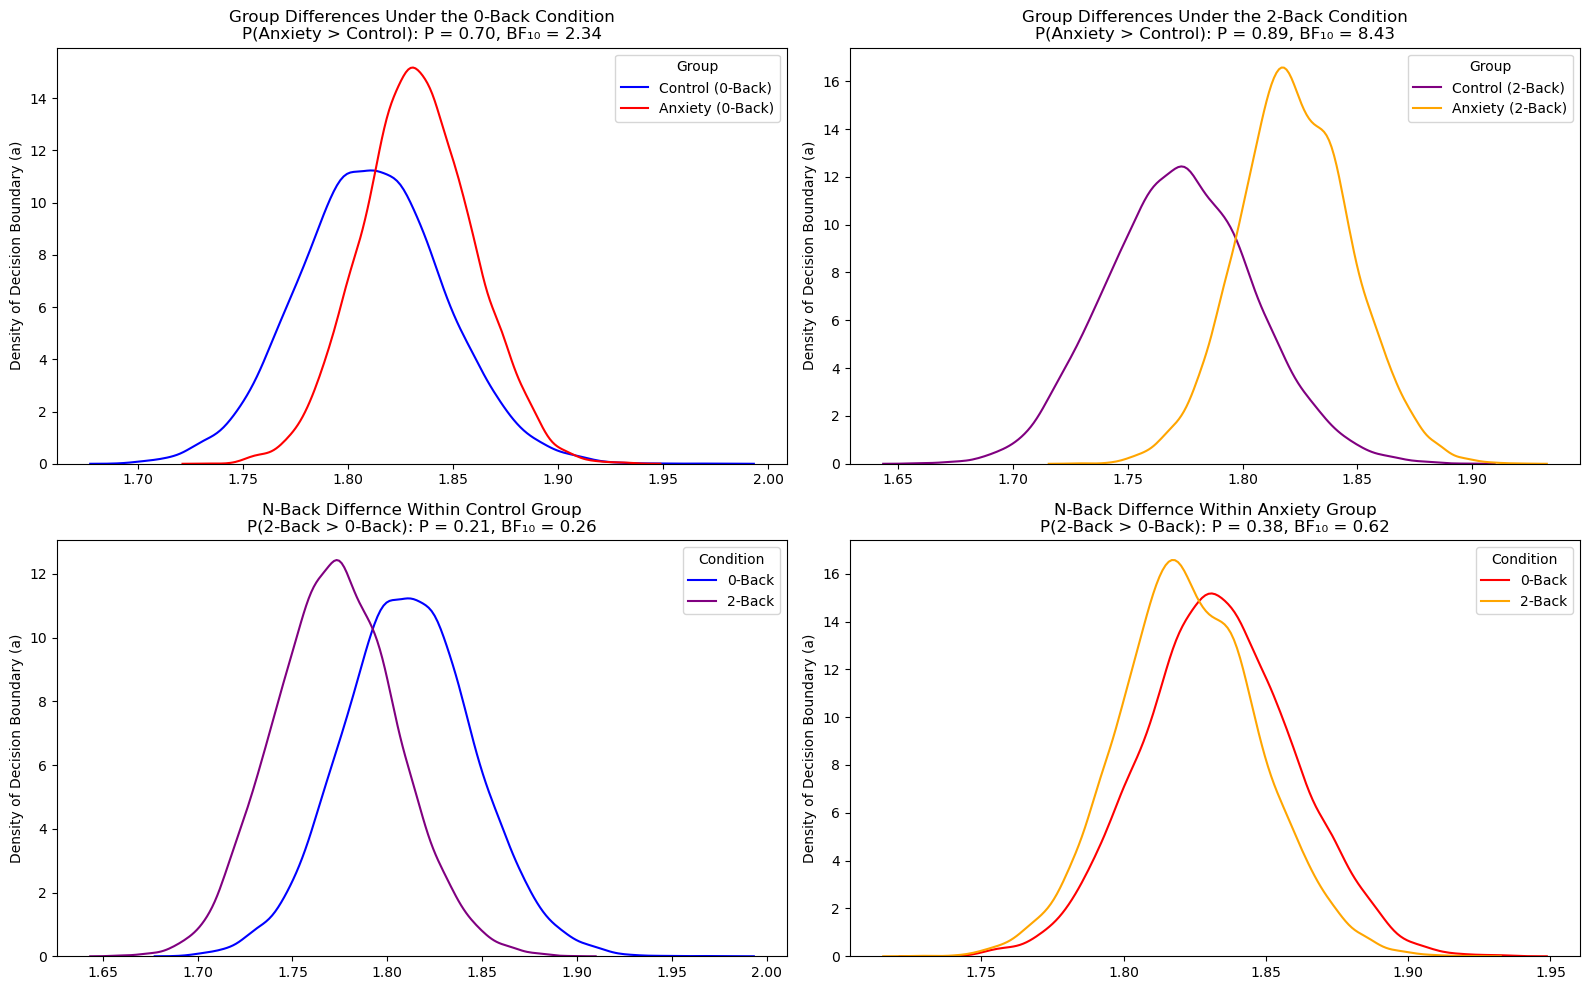


Processing parameter set: v


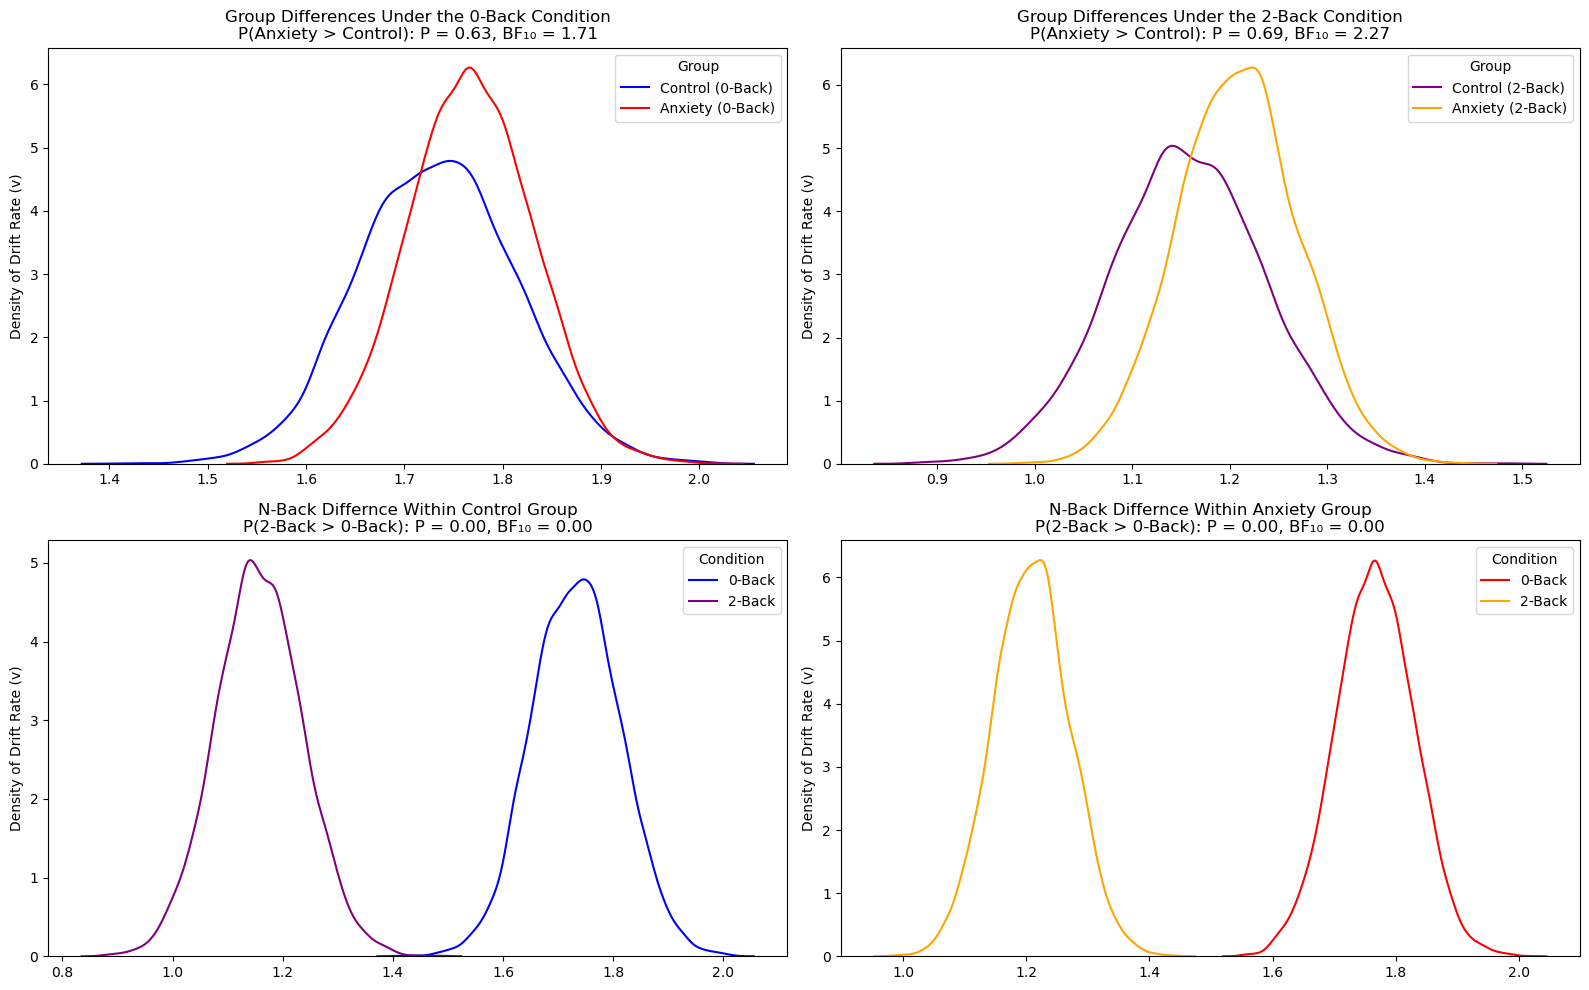


Processing parameter set: t


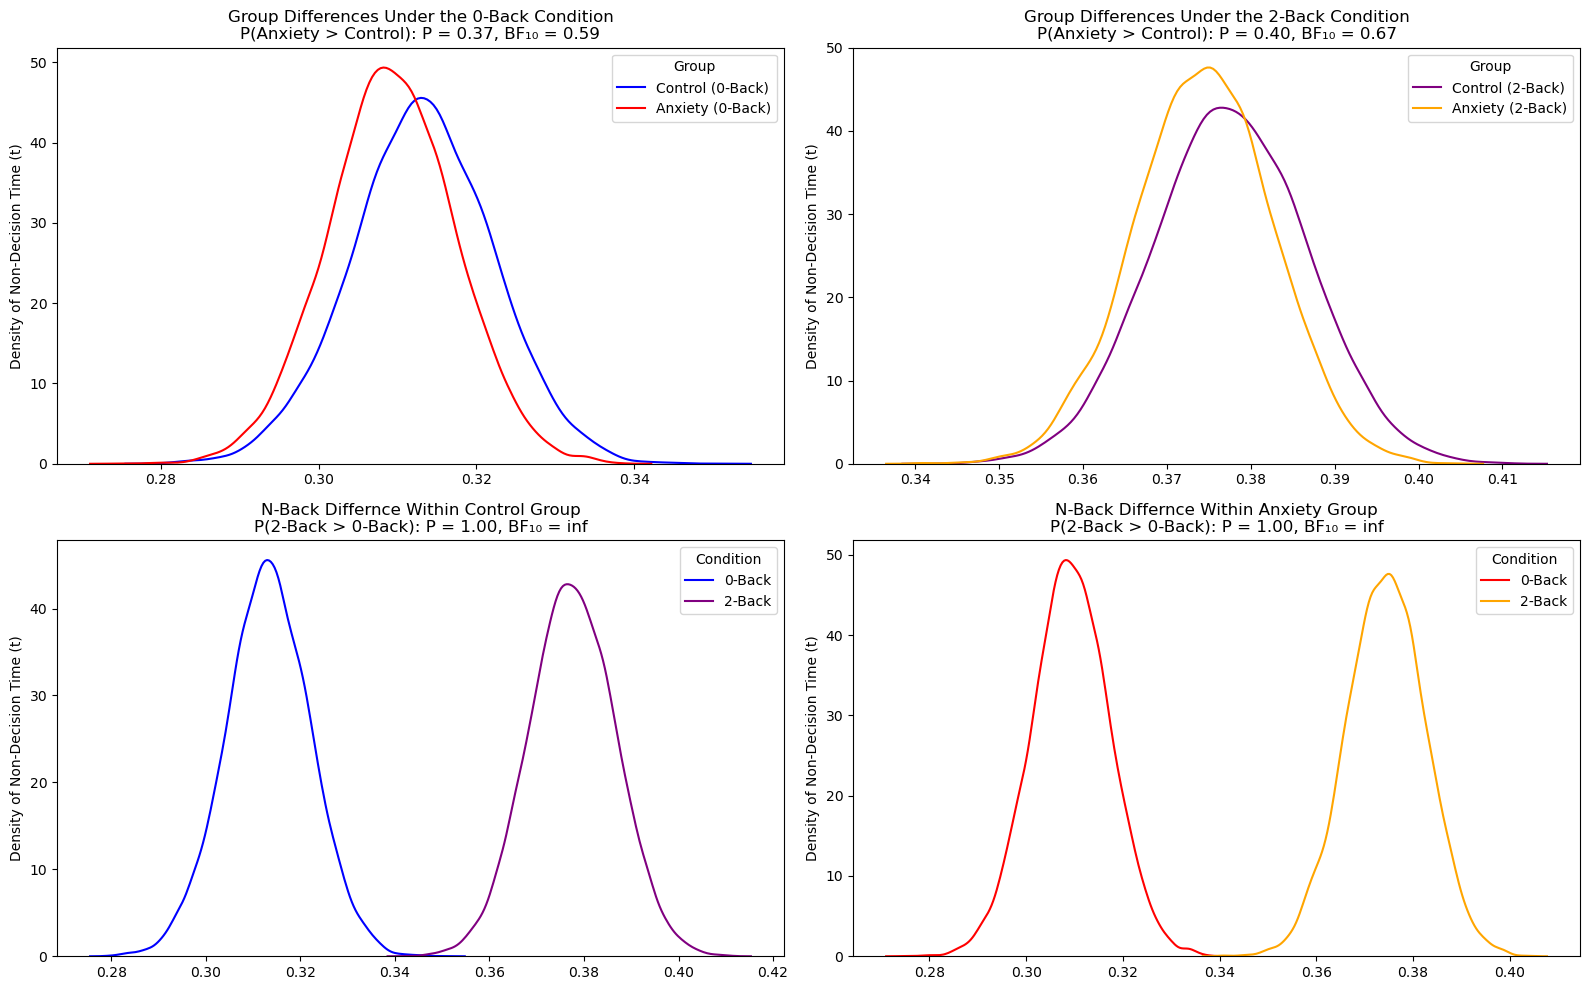

All graphs saved to 'All_Model0_2back_Plots.pdf' and results saved to 'Model0_2back_results.csv'


In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import arviz as az

# Define parameters in required order
parameters = {
    'a': 'Decision Boundary (a)',
    'v': 'Drift Rate (v)',
    't': 'Non-Decision Time (t)'
}

conditions = ["0-Back", "2-Back"]

# Load posterior samples
control_posterior = loaded_models["model0_1_anx0"]["infdata"]
anxiety_posterior = loaded_models["model0_1_anx1"]["infdata"]

# Prepare results
results_for_csv = []

# Initialize PDF for saving all plots
with PdfPages("All_Model0_2back_Plots.pdf") as pdf:
    for param_prefix in parameters:
        print(f"\nProcessing parameter set: {param_prefix}")

        # Extract samples
        control_0back = control_posterior.posterior.data_vars.get(f"{param_prefix}(0-Back)", None)
        control_2back = control_posterior.posterior.data_vars.get(f"{param_prefix}(2-Back)", None)
        anxiety_0back = anxiety_posterior.posterior.data_vars.get(f"{param_prefix}(0-Back)", None)
        anxiety_2back = anxiety_posterior.posterior.data_vars.get(f"{param_prefix}(2-Back)", None)

        # Safely check if any of the required variables are missing
        if any(x is None for x in [control_0back, control_2back, anxiety_0back, anxiety_2back]):
            print(f"Skipping {param_prefix} due to missing data.")
            continue

        # Flatten arrays
        control_0back = control_0back.values.flatten()
        control_2back = control_2back.values.flatten()
        anxiety_0back = anxiety_0back.values.flatten()
        anxiety_2back = anxiety_2back.values.flatten()

        # Probabilities and Bayes Factors
        within_control_prob = (control_2back > control_0back).mean()
        within_anxiety_prob = (anxiety_2back > anxiety_0back).mean()
        within_control_bf, _, within_control_int = compute_bayes_factor(within_control_prob)
        within_anxiety_bf, _, within_anxiety_int = compute_bayes_factor(within_anxiety_prob)
        between_prob_0back = (anxiety_0back > control_0back).mean()
        between_prob_2back = (anxiety_2back > control_2back).mean()
        between_bf_0back, _, between_int_0back = compute_bayes_factor(between_prob_0back)
        between_bf_2back, _, between_int_2back = compute_bayes_factor(between_prob_2back)

        # Store results
        results_for_csv.append({
            "Parameter": param_prefix,
            "P(2-Back > 0-Back) - Control": f"{within_control_prob:.3f}",
            "Bayes Factor (BF10) - Control": f"{within_control_bf:.3f} ({within_control_int})",
            "P(2-Back > 0-Back) - Anxiety": f"{within_anxiety_prob:.3f}",
            "Bayes Factor (BF10) - Anxiety": f"{within_anxiety_bf:.3f} ({within_anxiety_int})",
            "P(Anxiety > Control) - 0Back": f"{between_prob_0back:.3f}",
            "Bayes Factor (BF10) - 0Back": f"{between_bf_0back:.3f} ({between_int_0back})",
            "P(Anxiety > Control) - 2Back": f"{between_prob_2back:.3f}",
            "Bayes Factor (BF10) - 2Back": f"{between_bf_2back:.3f} ({between_int_2back})",
        })

        # Create KDE Plots (4 plots per parameter)
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        axes = axes.flatten()

        def format_legend_text(prob, bf):
            return f"P = {prob:.2f}, BF₁₀ = {bf:.2f}"

        # Graph 1: 0-Back comparison (Between-Group)
        axes[0].set_title(
            f"Group Differences Under the 0-Back Condition\n"
            f"P(Anxiety > Control): {format_legend_text(between_prob_0back, between_bf_0back)}"
        )
        sns.kdeplot(control_0back, label="Control (0-Back)", fill=False, color="blue", ax=axes[0])
        sns.kdeplot(anxiety_0back, label="Anxiety (0-Back)", fill=False, color="red", ax=axes[0])
        axes[0].set_ylabel(f"Density of {parameters[param_prefix]}")
        axes[0].legend(title="Group")

        # Graph 2: 2-Back comparison (Between-Group)
        axes[1].set_title(
            f"Group Differences Under the 2-Back Condition\n"
            f"P(Anxiety > Control): {format_legend_text(between_prob_2back, between_bf_2back)}"
        )
        sns.kdeplot(control_2back, label="Control (2-Back)", fill=False, color="purple", ax=axes[1])
        sns.kdeplot(anxiety_2back, label="Anxiety (2-Back)", fill=False, color="orange", ax=axes[1])
        axes[1].set_ylabel(f"Density of {parameters[param_prefix]}")
        axes[1].legend(title="Group")

        # Graph 3: Control - 0 vs. 2-Back (Within-Group)
        axes[2].set_title(
            f"N-Back Differnce Within Control Group\n"
            f"P(2-Back > 0-Back): {format_legend_text(within_control_prob, within_control_bf)}"
        )
        sns.kdeplot(control_0back, label="0-Back", fill=False, color="blue", ax=axes[2])
        sns.kdeplot(control_2back, label="2-Back", fill=False, color="purple", ax=axes[2])
        axes[2].set_ylabel(f"Density of {parameters[param_prefix]}")
        axes[2].legend(title="Condition")

        # Graph 4: Anxiety - 0 vs. 2-Back (Within-Group)
        axes[3].set_title(
            f"N-Back Differnce Within Anxiety Group\n"
            f"P(2-Back > 0-Back): {format_legend_text(within_anxiety_prob, within_anxiety_bf)}"
        )
        sns.kdeplot(anxiety_0back, label="0-Back", fill=False, color="red", ax=axes[3])
        sns.kdeplot(anxiety_2back, label="2-Back", fill=False, color="orange", ax=axes[3])
        axes[3].set_ylabel(f"Density of {parameters[param_prefix]}")
        axes[3].legend(title="Condition")


        # Layout
        plt.tight_layout()
        pdf.savefig(fig)
        plt.show()
# Save CSV results
pd.DataFrame(results_for_csv).to_csv("Model0_2back_results.csv", index=False)
print("All graphs saved to 'All_Model0_2back_Plots.pdf' and results saved to 'Model0_2back_results.csv'")


In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

# Define parameters and conditions
parameters = {
    'a': 'Decision Boundary (a)',
    'v': 'Drift Rate (v)',
    't': 'Non-Decision Time (t)'
}
conditions = ["0-Back.Cog", "0-Back.Emo", "2-Back.Cog", "2-Back.Emo"]

# Load posterior samples using ArviZ
control_posterior = loaded_models["model1_1_anx0"]["infdata"]
anxiety_posterior = loaded_models["model1_1_anx1"]["infdata"]

# Results storage
results_for_csv = []

# Format for graph titles
def format_legend_text(prob, bf):
    return f"P = {prob:.2f}, BF₁₀ = {bf:.2f}"

# Process each parameter

with PdfPages("All_Comparisons.pdf") as pdf:
    for param_prefix in parameters:
        print(f"\nProcessing parameter: {param_prefix}")

        # Extract samples
        samples = {}
        for model_name, posterior in zip(["Control", "Anxiety"], [control_posterior, anxiety_posterior]):
            for cond in conditions:
                key = f"{param_prefix}({cond})"
                if key in posterior.posterior.data_vars:
                    samples[f"{model_name}_{cond}"] = posterior.posterior[key].values.flatten()

        # Skip parameter if any condition is missing
        if len(samples) < len(conditions) * 2:
            print(f"Skipping {param_prefix} due to missing data.")
            continue

        # Define comparisons
        cross_model_comparisons = [
            ("Anxiety_0-Back.Cog", "Control_0-Back.Cog", "0-Back Cog: Anxiety vs Control"),
            ("Anxiety_0-Back.Emo", "Control_0-Back.Emo", "0-Back Emo: Anxiety vs Control"),
            ("Anxiety_2-Back.Cog", "Control_2-Back.Cog", "2-Back Cog: Anxiety vs Control"),
            ("Anxiety_2-Back.Emo", "Control_2-Back.Emo", "2-Back Emo: Anxiety vs Control"),
        ]
        within_model_comparisons = [
            ("Control_0-Back.Emo", "Control_0-Back.Cog", "Control: 0-Back Emo vs Cog"),
            ("Control_2-Back.Emo", "Control_2-Back.Cog", "Control: 2-Back Emo vs Cog"),
            ("Control_2-Back.Cog", "Control_0-Back.Cog", "Control: Cog 2-Back vs 0-Back"),
            ("Control_2-Back.Emo", "Control_0-Back.Emo", "Control: Emo 2-Back vs 0-Back"),
            ("Anxiety_0-Back.Emo", "Anxiety_0-Back.Cog", "Anxiety: 0-Back Emo vs Cog"),
            ("Anxiety_2-Back.Emo", "Anxiety_2-Back.Cog", "Anxiety: 2-Back Emo vs Cog"),
            ("Anxiety_2-Back.Cog", "Anxiety_0-Back.Cog", "Anxiety: Cog 2-Back vs 0-Back"),
            ("Anxiety_2-Back.Emo", "Anxiety_0-Back.Emo", "Anxiety: Emo 2-Back vs 0-Back"),      
        ]

        # Create KDE Plots
        fig, axes = plt.subplots(6, 2, figsize=(16, 22))
        axes = axes.flatten()

        # Combine comparisons
        all_comparisons = cross_model_comparisons + within_model_comparisons[:8]

        for idx, (cond1, cond2, title) in enumerate(all_comparisons):
            trace1 = samples[cond1]
            trace2 = samples[cond2]

            prob = (trace1 > trace2).mean()
            bf_10, bf_01, interpretation = compute_bayes_factor(prob)

            # Stats for trace 1
            mean1 = np.mean(trace1)
            sd1 = np.std(trace1)
            hdi1 = az.hdi(trace1, hdi_prob=0.95)

            # Stats for trace 2
            mean2 = np.mean(trace2)
            sd2 = np.std(trace2)
            hdi2 = az.hdi(trace2, hdi_prob=0.95)

            # Store results
            results_for_csv.append({
                "Parameter": param_prefix,
                "Comparison": title,
                "P(Cond1 > Cond2)": f"{prob:.2f}",
                "Bayes Factor (BF10)": f"{bf_10:.2f}",
                "Bayes Factor (BF01)": f"{bf_01:.2f}",
                "Bayes Interpretation": interpretation,
                "Mean A": f"{mean1:.2f}",
                "SD A": f"{sd1:.2f}",
                "HDI A Lower": f"{hdi1[0]:.2f}",
                "HDI A Upper": f"{hdi1[1]:.2f}",
                "Mean B": f"{mean2:.2f}",
                "SD B": f"{sd2:.2f}",
                "HDI B Lower": f"{hdi2[0]:.2f}",
                "HDI B Upper": f"{hdi2[1]:.2f}",
            })

            # Determine legend title based on group
           # Determine legend title
            if cond1.startswith("Anxiety") and cond2.startswith("Control"):
                legend_title = "Between Group"
            else:
                cond1_label = cond1.split('_')[1]  # e.g., "0-Back.Cog"
                cond2_label = cond2.split('_')[1]

                nback1, stim1 = cond1_label.split('.')
                nback2, stim2 = cond2_label.split('.')

                if nback1 == nback2:
                    legend_title = "Within Group (Stimulus Type Difference)"
                elif stim1 == stim2:
                    legend_title = "Within Group (N-Back Difference)"
                else:
                    legend_title = "Within Group"
            # Full condition names with group
            label_A_name = f"{cond1.split('_')[0]}: {cond1.split('_')[1]}"
            label_B_name = f"{cond2.split('_')[0]}: {cond2.split('_')[1]}"

            # Include stats in legend labels
            label_A = f"{label_A_name} (A): μ={mean1:.2f}, σ={sd1:.2f}, HDI=[{hdi1[0]:.2f}, {hdi1[1]:.2f}]"
            label_B = f"{label_B_name} (B): μ={mean2:.2f}, σ={sd2:.2f}, HDI=[{hdi2[0]:.2f}, {hdi2[1]:.2f}]"


            # Plot
            axes[idx].set_title(
                f"{title}\nP(A > B): {format_legend_text(prob, bf_10)}\nInterpretation: {interpretation}"
            )
            sns.kdeplot(trace1, label=label_A, fill=True, color="blue", alpha=0.5, ax=axes[idx])
            sns.kdeplot(trace2, label=label_B, fill=True, color="orange", alpha=0.5, ax=axes[idx])
            axes[idx].set_xlabel(parameters[param_prefix])
            axes[idx].set_ylabel("Density")
            axes[idx].legend(title=legend_title)

        # Layout & Save
        fig.subplots_adjust(hspace=1.2, wspace=0.3)
        plt.tight_layout()
        plt.savefig(f"summary_{param_prefix}.png", dpi=300, bbox_inches='tight')  # Optional PNG export
        pdf.savefig(fig, bbox_inches='tight')  # Save to combined PDF
        plt.close(fig) 
        plt.show()

    # Save results to CSV
pd.DataFrame(results_for_csv).to_csv("Model1_2back_results.csv", index=False)
print("Results saved to Model1_2back_results.csv")



Processing parameter: a

Processing parameter: v

Processing parameter: t
Results saved to Model1_2back_results.csv


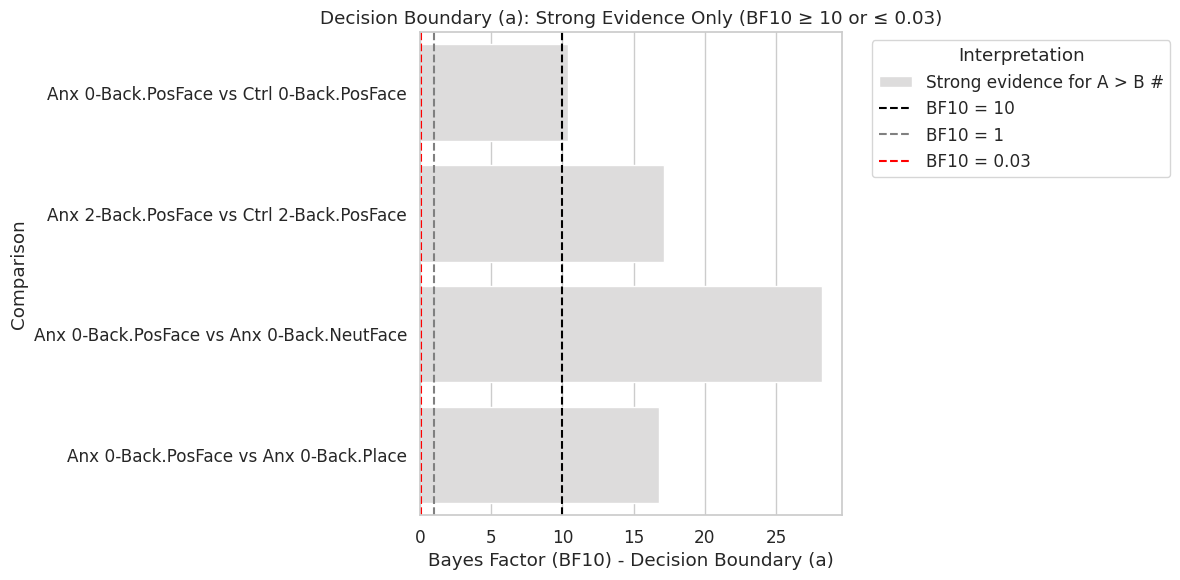

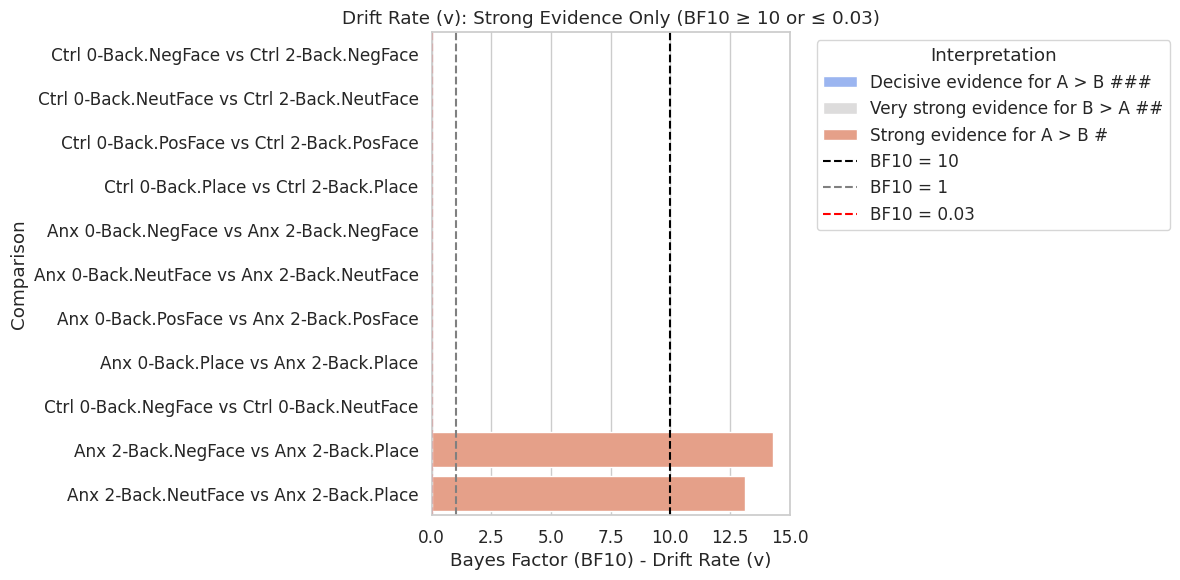

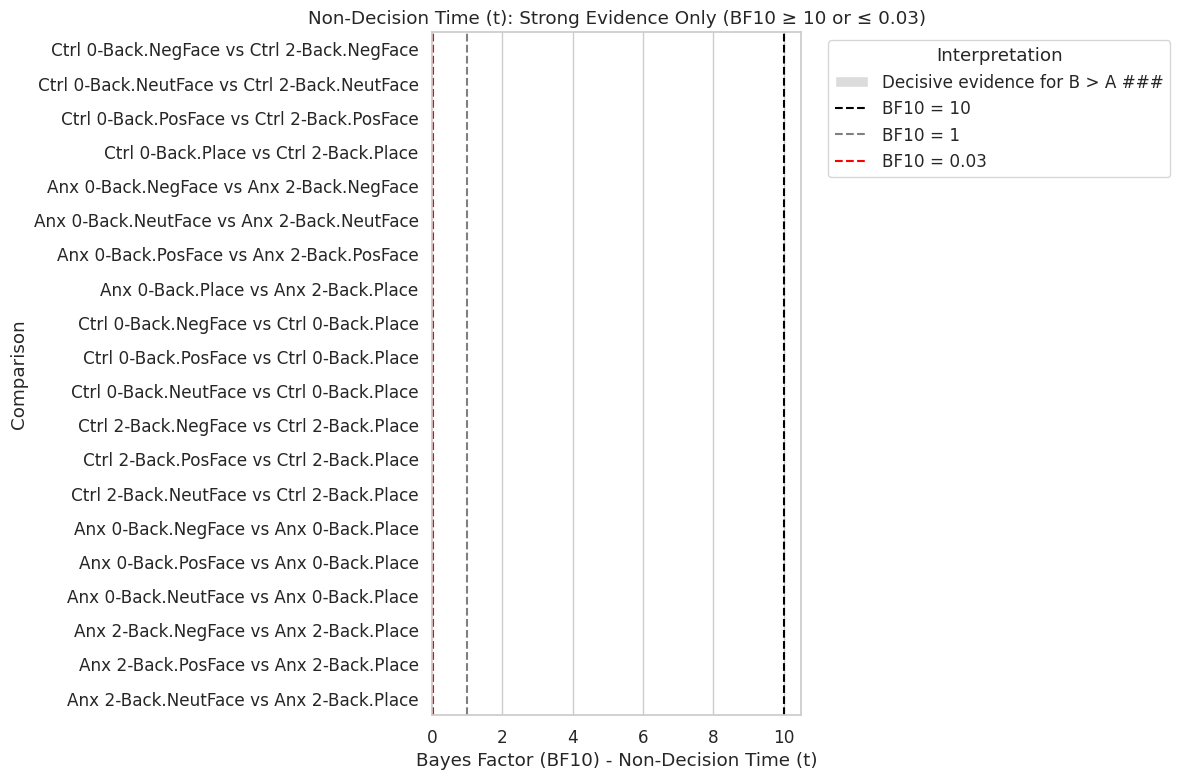

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.autolayout"] = True

# Define parameters and conditions
parameters = {
    'a': 'Decision Boundary (a)',
    'v': 'Drift Rate (v)',
    't': 'Non-Decision Time (t)'
}
conditions = ["0-Back.NegFace", "0-Back.NeutFace", "0-Back.Place", "0-Back.PosFace",
              "2-Back.NegFace", "2-Back.NeutFace", "2-Back.Place", "2-Back.PosFace"]

# Load posterior samples for Anxiety and Control groups
control_posterior = loaded_models["model2_2_anx0"]["infdata"]
anxiety_posterior = loaded_models["model2_2_anx1"]["infdata"]

# Extract samples
samples = {}
for model_name, posterior in zip(["Control", "Anxiety"], [control_posterior, anxiety_posterior]):
    for cond in conditions:
        for param in parameters:
            param_name = f"{param}({cond})"
            extracted_samples = get_param_samples(posterior, param_name)
            if extracted_samples is not None:
                samples[f"{model_name}_{cond}_{param}"] = extracted_samples

# Define comparison categories properly
cross_model_comparisons = {
    "Valence Effect On 0-Back Between Anxiety condition": [
        ("Anxiety_0-Back.NegFace", "Control_0-Back.NegFace"),
        ("Anxiety_0-Back.NeutFace", "Control_0-Back.NeutFace"),
        ("Anxiety_0-Back.PosFace", "Control_0-Back.PosFace"),
        ("Anxiety_0-Back.Place", "Control_0-Back.Place")
    ],
    "Valence Effect On 2-Back Between Anxiety condition": [    
        ("Anxiety_2-Back.NegFace", "Control_2-Back.NegFace"),
        ("Anxiety_2-Back.NeutFace", "Control_2-Back.NeutFace"),
        ("Anxiety_2-Back.PosFace", "Control_2-Back.PosFace"),
        ("Anxiety_2-Back.Place", "Control_2-Back.Place"),
    ]
}

within_model_comparisons = {
   "Valence Effect On Control Between Cognitive Load conditon": [
        ("Control_0-Back.NegFace", "Control_2-Back.NegFace"),
        ("Control_0-Back.NeutFace", "Control_2-Back.NeutFace"),
        ("Control_0-Back.PosFace", "Control_2-Back.PosFace"),
        ("Control_0-Back.Place", "Control_2-Back.Place")
    ],
    "Valence Effect On Axinety Between Cognitive Load conditon": [
        ("Anxiety_0-Back.NegFace", "Anxiety_2-Back.NegFace"),
        ("Anxiety_0-Back.NeutFace", "Anxiety_2-Back.NeutFace"),
        ("Anxiety_0-Back.PosFace", "Anxiety_2-Back.PosFace"),
        ("Anxiety_0-Back.Place", "Anxiety_2-Back.Place")
    ],
    
    "Valence Effect within contorl 0-back": [
        ("Control_0-Back.NegFace", "Control_0-Back.NeutFace"),
        ("Control_0-Back.NegFace", "Control_0-Back.PosFace"),
        ("Control_0-Back.NegFace", "Control_0-Back.Place"),
        ("Control_0-Back.PosFace", "Control_0-Back.NeutFace"),
        ("Control_0-Back.PosFace", "Control_0-Back.Place"),
        ("Control_0-Back.NeutFace", "Control_0-Back.Place")
    ],
     "Valence Effect within contorl 2-back": [    
        ("Control_2-Back.NegFace", "Control_2-Back.NeutFace"),
        ("Control_2-Back.NegFace", "Control_2-Back.PosFace"),
        ("Control_2-Back.NegFace", "Control_2-Back.Place"),
        ("Control_2-Back.PosFace", "Control_2-Back.NeutFace"),
        ("Control_2-Back.PosFace", "Control_2-Back.Place"),
        ("Control_2-Back.NeutFace", "Control_2-Back.Place"),
     ],
     "Valence Effect within Anxiety 0-back": [  
        ("Anxiety_0-Back.NegFace", "Anxiety_0-Back.NeutFace"),
        ("Anxiety_0-Back.NegFace", "Anxiety_0-Back.PosFace"),
        ("Anxiety_0-Back.NegFace", "Anxiety_0-Back.Place"),
        ("Anxiety_0-Back.PosFace", "Anxiety_0-Back.NeutFace"),
        ("Anxiety_0-Back.PosFace", "Anxiety_0-Back.Place"),
        ("Anxiety_0-Back.NeutFace", "Anxiety_0-Back.Place"),
     ],
     "Valence Effect within Anxiety 2-back": [  
        ("Anxiety_2-Back.NegFace", "Anxiety_2-Back.NeutFace"),
        ("Anxiety_2-Back.NegFace", "Anxiety_2-Back.PosFace"),
        ("Anxiety_2-Back.NegFace", "Anxiety_2-Back.Place"),
        ("Anxiety_2-Back.PosFace", "Anxiety_2-Back.NeutFace"),
        ("Anxiety_2-Back.PosFace", "Anxiety_2-Back.Place"),
        ("Anxiety_2-Back.NeutFace", "Anxiety_2-Back.Place"),
    ]
}

# Simple label formatter
def pretty(label):
    return label.replace("Anxiety_", "Anx ").replace("Control_", "Ctrl ")

# Store results
results_for_csv = []

for param, param_label in parameters.items():
    plot_data = []

    # --- Cross-model comparisons ---
    for category, comparisons in cross_model_comparisons.items():
        for cond1, cond2 in comparisons:
            key1, key2 = f"{cond1}_{param}", f"{cond2}_{param}"
            if key1 in samples and key2 in samples:
                s1, s2 = samples[key1], samples[key2]
                prob = (s1 > s2).mean()
                bf_10, bf_01, interpretation = compute_bayes_factor(prob)

                plot_data.append({
                    "Comparison": f"{pretty(cond1)} vs {pretty(cond2)}",
                    "BF10": bf_10,
                    "BF01": bf_01,
                    "Interpretation": interpretation,
                    "Category": category,
                    "Parameter": param_label
                })

                results_for_csv.append({
                    "Parameter": param_label,
                    "Comparison": f"{pretty(cond1)} vs {pretty(cond2)}",
                    "P(Cond1 > Cond2)": round(prob, 3),
                    "BF10": round(bf_10, 3),
                    "BF01": round(bf_01, 3),
                    "Interpretation": interpretation
                })

    # --- Within-model comparisons ---
    for category, comparisons in within_model_comparisons.items():
        for cond1, cond2 in comparisons:
            key1, key2 = f"{cond1}_{param}", f"{cond2}_{param}"
            if key1 in samples and key2 in samples:
                s1, s2 = samples[key1], samples[key2]
                prob = (s1 > s2).mean()
                bf_10, bf_01, interpretation = compute_bayes_factor(prob)

                plot_data.append({
                    "Comparison": f"{pretty(cond1)} vs {pretty(cond2)}",
                    "BF10": bf_10,
                    "BF01": bf_01,
                    "Interpretation": interpretation,
                    "Category": category,
                    "Parameter": param_label
                })

                results_for_csv.append({
                    "Parameter": param_label,
                    "Comparison": f"{pretty(cond1)} vs {pretty(cond2)}",
                    "P(Cond1 > Cond2)": round(prob, 3),
                    "BF10": round(bf_10, 3),
                    "BF01": round(bf_01, 3),
                    "Interpretation": interpretation
                })

    # --- Filter and plot ---
    df_plot = pd.DataFrame(plot_data)
    df_plot = df_plot[(df_plot["BF10"] >= 10) | (df_plot["BF10"] <= 0.03)]

    if not df_plot.empty:
        plt.figure(figsize=(12, max(6, len(df_plot) * 0.4)))
        ax = sns.barplot(
            data=df_plot,
            x="BF10", y="Comparison",
            hue="Interpretation",
            dodge=False,
            palette="coolwarm"
        )

        plt.axvline(10, color="black", linestyle="--", label="BF10 = 10")
        plt.axvline(1, color="gray", linestyle="--", label="BF10 = 1")
        plt.axvline(0.03, color="red", linestyle="--", label="BF10 = 0.03")
        plt.xlabel(f"Bayes Factor (BF10) - {param_label}")
        plt.title(f"{param_label}: Strong Evidence Only (BF10 ≥ 10 or ≤ 0.03)")
        plt.legend(title="Interpretation", bbox_to_anchor=(1.05, 1), loc="upper left")

        plt.tight_layout()
        plt.savefig(f"Filtered_BF10_{param}.pdf", bbox_inches="tight")
        df_plot.to_csv(f"Filtered_BF10_{param}.csv", index=False)
        plt.show()
    else:
        print(f"No strong/weak evidence for {param_label}")

# Save all results
pd.DataFrame(results_for_csv).to_csv("Model2_2back_results_all.csv", index=False)


In [49]:

# Define models and settings
models_1 = {
    "model0": model0_settings,
    "model1": model1_settings,
    "model2": model2_settings,
}

# Initialize dictionary to store models
loaded_models = {}

# Loop through each model for loading with anxiety0 and anxiety1
for anxiety_status in ["anx0", "anx1"]:
    for model_name in models_1.keys():
        try:
            # Define model variable name with anxiety state
            model_var_name = f"{model_name}_{anxiety_status}"
            nc_name = f"{model_var_name}_infdata.nc"

            # Load HDDM model
            model_file = f"{model_var_name}"  # Adjust if different
            loaded_model = hddm.load(model_file)
            print(f"HDDM Model Loaded: {model_var_name}")

            # Load inference data
            infdata = az.from_netcdf(nc_name)
            print(f"Inference Data Loaded: {nc_name}")

            # Extract all variable names
            all_vars = list(infdata.posterior.data_vars)

            # Filter out variables containing "subj"
            filtered_vars = [var for var in all_vars if "subj" not in var]

            # Generate summary excluding 'subj' variables
            summary = az.summary(infdata, var_names=filtered_vars, round_to=4)

            # Store everything in the dictionary
            loaded_models[model_var_name] = {
                "model": loaded_model,
                "infdata": infdata,
                "summary": summary
            }

            # Print summary
            print(f"\nSummary for {model_var_name}:")
            print(summary)

        except Exception as e:
            print(f"Error loading {model_var_name}: {e}")


HDDM Model Loaded: model0_anx0
Inference Data Loaded: model0_anx0_infdata.nc

Summary for model0_anx0:
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk   
a      1.7974  0.0268  1.7471   1.8474     0.0004   0.0003  4834.4239  \
a_std  0.2219  0.0220  0.1801   0.2621     0.0004   0.0003  3466.8240   
v      1.3429  0.0670  1.2159   1.4681     0.0007   0.0005  9372.9753   
v_std  0.6314  0.0505  0.5407   0.7300     0.0005   0.0004  9061.7554   
t      0.3175  0.0071  0.3041   0.3312     0.0001   0.0001  6439.2714   
t_std  0.0633  0.0055  0.0531   0.0735     0.0001   0.0001  5064.5596   

        ess_tail   r_hat  
a      6656.8759  1.0001  
a_std  6008.6704  1.0007  
v      9218.5940  0.9999  
v_std  8836.2668  1.0004  
t      7950.1672  1.0001  
t_std  7754.2291  1.0010  
HDDM Model Loaded: model1_anx0
Inference Data Loaded: model1_anx0_infdata.nc

Summary for model1_anx0:
          mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk   
a(Cog)  1.8004  0.0

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
# Ensure results list is initialized
results_for_csv = []

# Define parameters and their readable names
parameters = {
    'a': 'Decision Boundary (a)',
    'v': 'Drift Rate (v)',
    't': 'Non-Decision Time (t)'
}
model_var_names = {"Control": "model0_anx0", "Anxiety": "model0_anx1"}

with PdfPages("Posterior Distributions and Bayesian Comparisons on Anxiety Group.pdf") as pdf:
    for param_name in parameters:
        try:
            control_samples = get_param_samples(loaded_models["model0_anx0"]["infdata"], param_name)
            anxiety_samples = get_param_samples(loaded_models["model0_anx1"]["infdata"], param_name)

            probability = (anxiety_samples > control_samples).mean()
            bf_10, bf_01, interpretation = compute_bayes_factor(probability)

            # Posterior stats
            mean_ctrl, std_ctrl = np.mean(control_samples), np.std(control_samples)
            mean_anx, std_anx = np.mean(anxiety_samples), np.std(anxiety_samples)
            hdi_ctrl = az.hdi(control_samples, hdi_prob=0.95)
            hdi_anx = az.hdi(anxiety_samples, hdi_prob=0.95)

            label_ctrl = (f"Control: μ={mean_ctrl:.2f}, σ={std_ctrl:.2f}, "
                          f"HDI=[{hdi_ctrl[0]:.2f}, {hdi_ctrl[1]:.2f}]")
            label_anx = (f"Anxiety: μ={mean_anx:.2f}, σ={std_anx:.2f}, "
                         f"HDI=[{hdi_anx[0]:.2f}, {hdi_anx[1]:.2f}]")

            def format_legend_text(prob, bf):
                return f"P = {prob:.2f}, BF₁₀ = {bf:.2f}"

            summary_title = f"{parameters[param_name]}: Anxiety vs. Control\n" + \
                            f"{format_legend_text(probability, bf_10)}, Interpretation: {interpretation}"

            fig, ax = plt.subplots(figsize=(10, 6))
            sns.kdeplot(control_samples, label=label_ctrl, fill=False, color='blue', alpha=0.5, ax=ax)
            sns.kdeplot(anxiety_samples, label=label_anx, fill=False, color='red', alpha=0.5, ax=ax)

            ax.set_xlabel(parameters[param_name])
            ax.set_ylabel("Density")
            ax.set_title(summary_title)
            ax.legend(title="Between Group")

            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)

            # Append to CSV results
            results_for_csv.append({
                "Parameter": parameters[param_name],
                "Comparison": "Anxiety vs. Control",
                "P(Anx > Ctrl)": round(probability, 4),
                "Bayes Factor (BF10)": round(bf_10, 4),
                "Bayes Factor (BF01)": round(bf_01, 4),
                "Interpretation": interpretation
            })

        except KeyError:
            print(f"Missing parameter data for {param_name}, skipping.")
# Save results to CSV
csv_filename = "model0_probability_results.csv"
with open(csv_filename, mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=["Parameter", "Comparison", "P(Anx > Ctrl)", "Bayes Factor (BF10)", "Bayes Factor (BF01)", "Interpretation"])
    writer.writeheader()
    writer.writerows(results_for_csv)

print(f"Saved combined PDF as 'Posterior Distributions and Bayesian Comparisons on Anxiety Group.pdf'")
print(f"Probability results saved to '{csv_filename}'")


Saved combined PDF as 'Posterior Distributions and Bayesian Comparisons on Anxiety Group.pdf'
Probability results saved to 'model0_probability_results.csv'


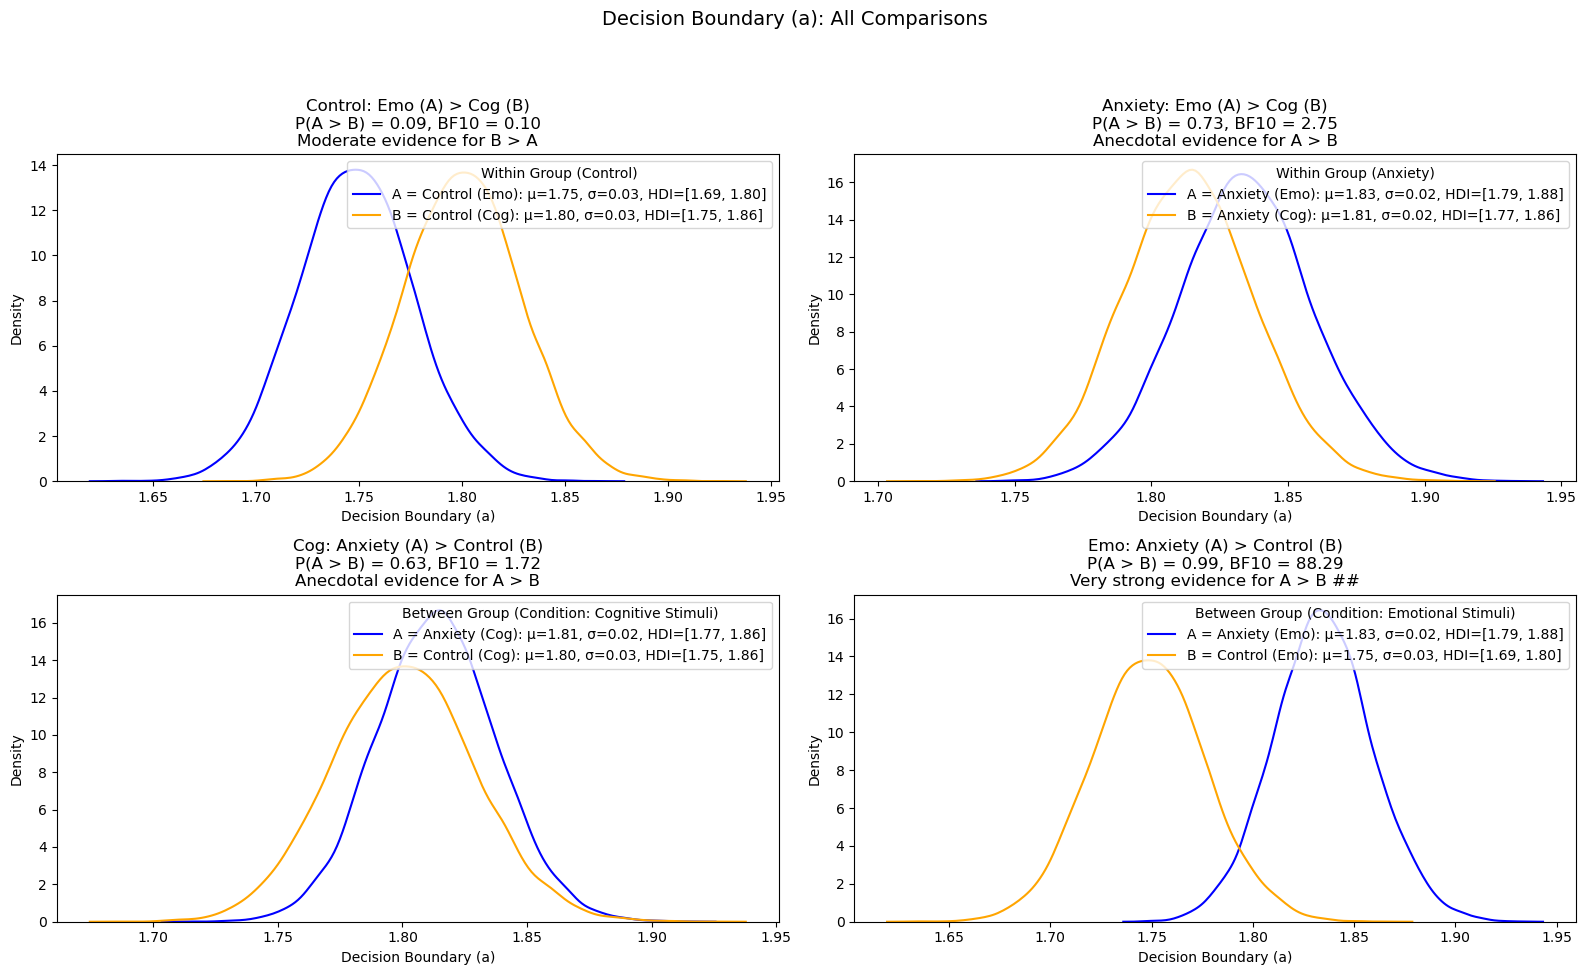

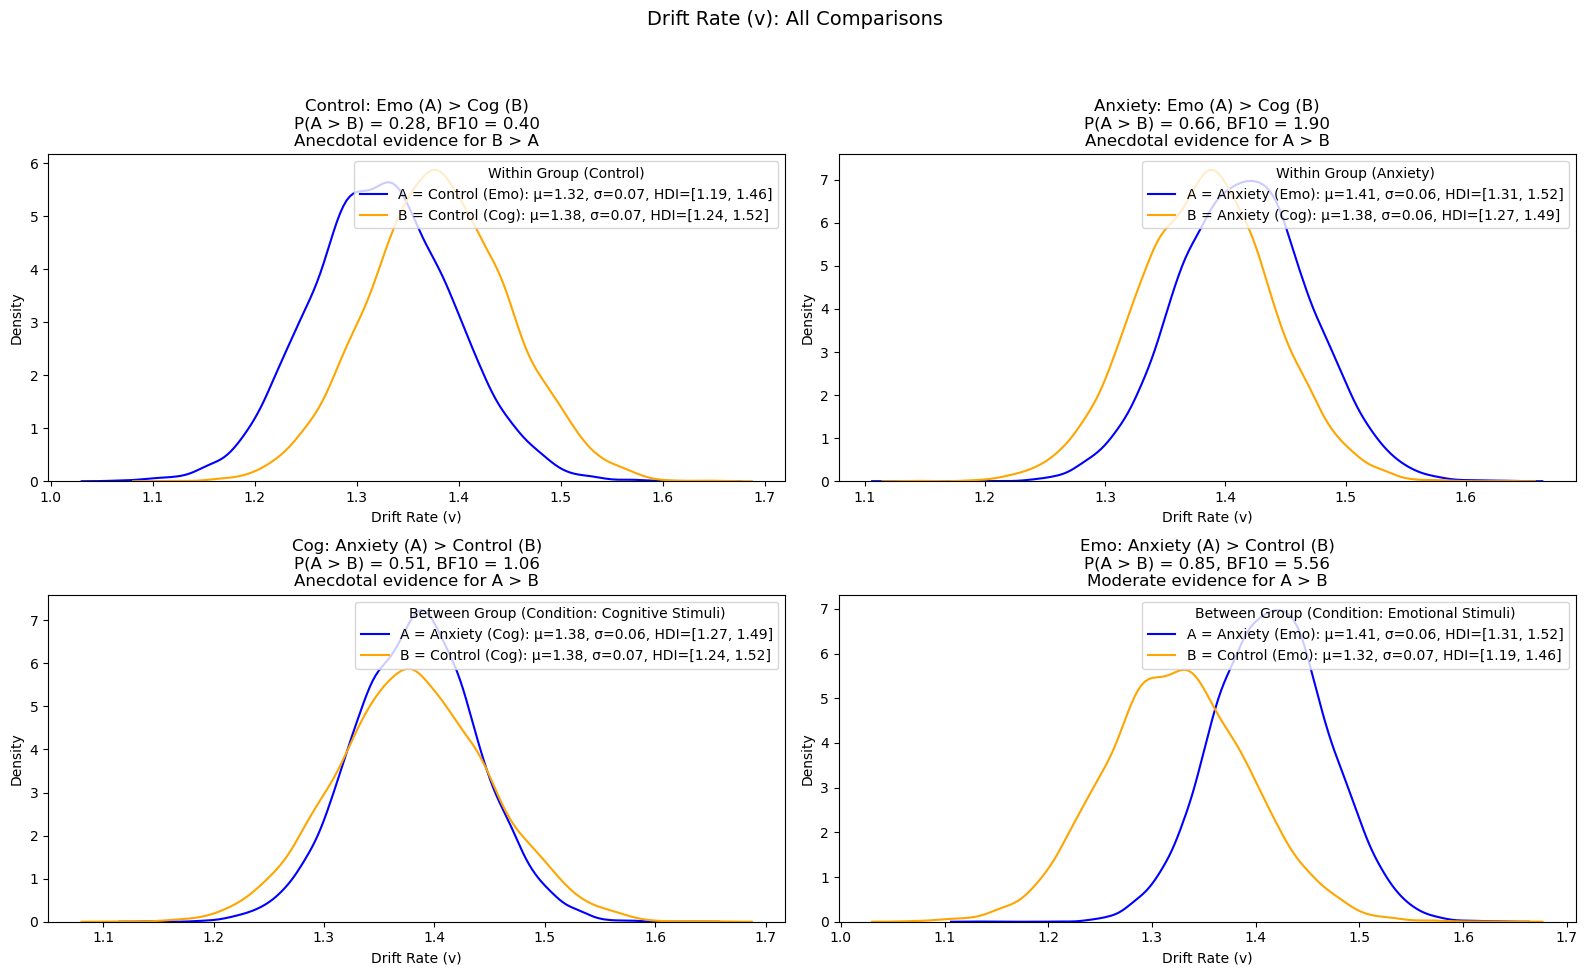

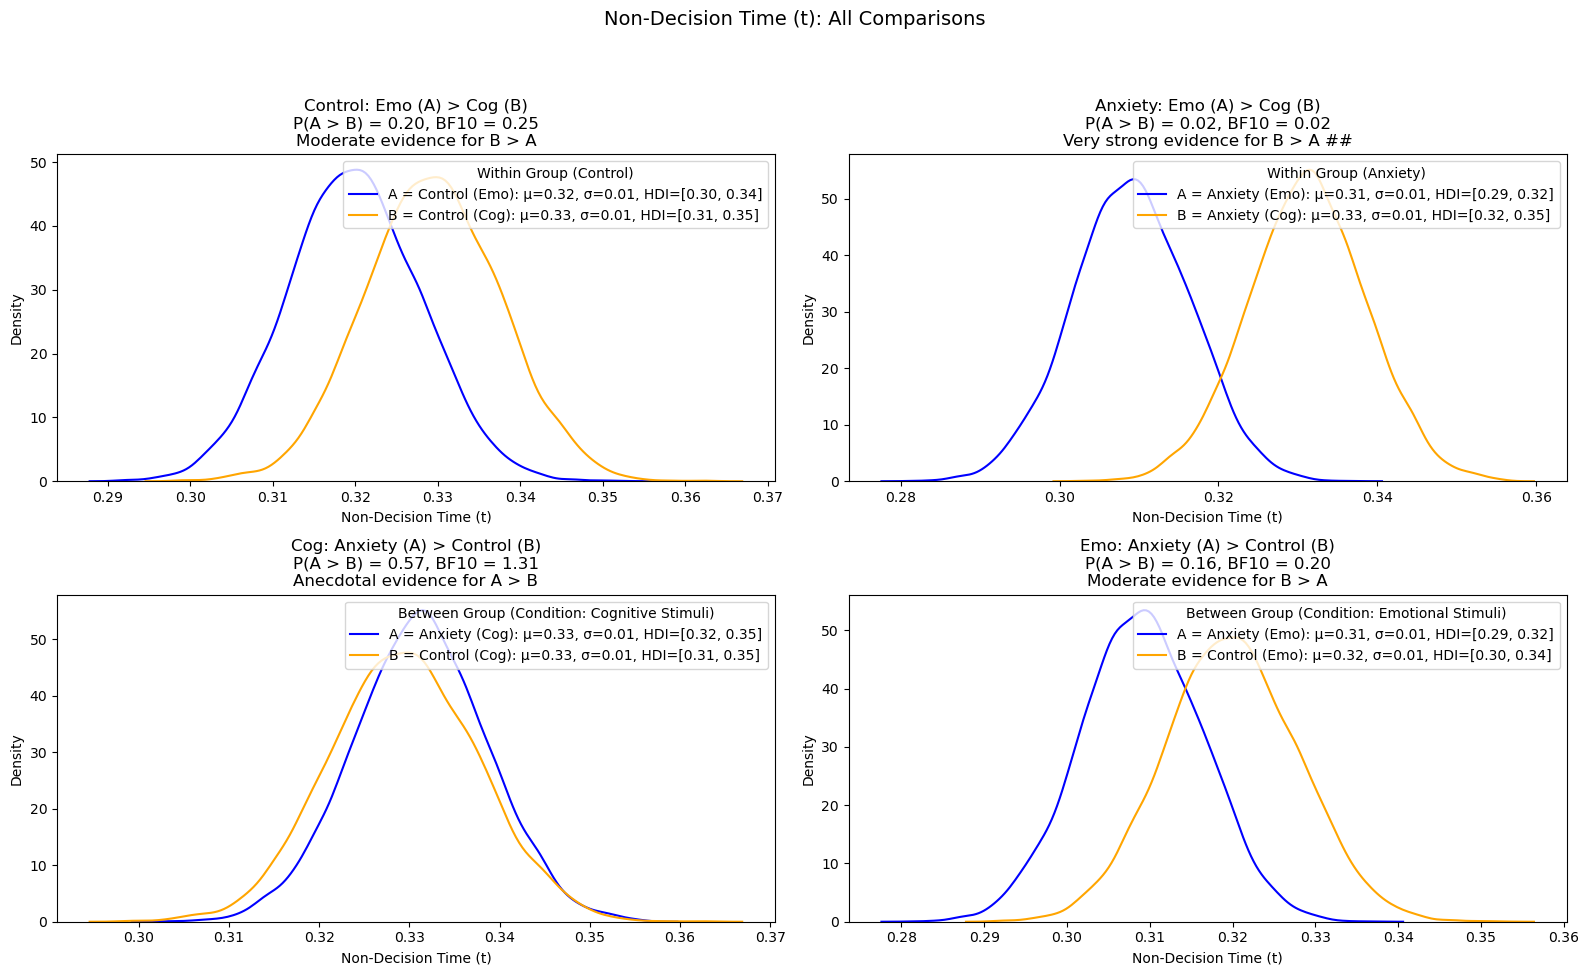

✅ Saved: Posterior Distributions and Bayesian Comparisons for Cognitive vs. Emotional Conditions in Anxiety and Control Groups.pdf and model1_probability_results.csv


In [69]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import arviz as az

# Parameters and conditions
parameters = {
    'a': 'Decision Boundary (a)',
    'v': 'Drift Rate (v)',
    't': 'Non-Decision Time (t)'
}
conditions = ["Cog", "Emo"]

# Save figures and results
results_for_csv = []

with PdfPages("Posterior Distributions and Bayesian Comparisons for Cognitive vs. Emotional Conditions in Anxiety and Control Groups.pdf") as pdf:
    for param_name in parameters:
        try:
            samples = {
                f"{cond}_0": get_param_samples(loaded_models["model1_anx0"]["infdata"], f"{param_name}({cond})")
                for cond in conditions
            } | {
                f"{cond}_1": get_param_samples(loaded_models["model1_anx1"]["infdata"], f"{param_name}({cond})")
                for cond in conditions
            }

            if any(v is None for v in samples.values()):
                print(f"Missing parameter data for {param_name}, skipping.")
                continue

            # Between-group comparisons
            probs = {
                cond: (samples[f"{cond}_1"] > samples[f"{cond}_0"]).mean()
                for cond in conditions
            }
            bfs = {
                cond: compute_bayes_factor(probs[cond])
                for cond in conditions
            }

            # Within-group
            wc_prob = (samples["Emo_0"] > samples["Cog_0"]).mean()
            wa_prob = (samples["Emo_1"] > samples["Cog_1"]).mean()
            wc_bf = compute_bayes_factor(wc_prob)
            wa_bf = compute_bayes_factor(wa_prob)

            # Save results
            for cond in conditions:
                bf10, bf01, interp = bfs[cond]
                results_for_csv.append({
                    "Parameter": parameters[param_name],
                    "Comparison": f"Anxiety vs. Control ({cond})",
                    "P(Anxiety > Control)": round(probs[cond], 2),
                    "BF10": round(bf10, 2),
                    "BF01": round(bf01, 2),
                    "Interpretation": interp
                })

            results_for_csv.extend([
                {
                    "Parameter": parameters[param_name],
                    "Comparison": "Within-Control (Emo > Cog)",
                    "P(Emo > Cog)": round(wc_prob, 2),
                    "BF10": round(wc_bf[0], 2),
                    "BF01": round(wc_bf[1], 2),
                    "Interpretation": wc_bf[2]
                },
                {
                    "Parameter": parameters[param_name],
                    "Comparison": "Within-Anxiety (Emo > Cog)",
                    "P(Emo > Cog)": round(wa_prob, 2),
                    "BF10": round(wa_bf[0], 2),
                    "BF01": round(wa_bf[1], 2),
                    "Interpretation": wa_bf[2]
                }
            ])

            # Plot setup
            fig, axes = plt.subplots(2, 2, figsize=(16, 10))
            axes = axes.flatten()

            plot_data = [
                ("Emo_0", "Cog_0", "Control: Emo (A) > Cog (B)", wc_prob, wc_bf, "Within Group (Control)"),
                ("Emo_1", "Cog_1", "Anxiety: Emo (A) > Cog (B)", wa_prob, wa_bf, "Within Group (Anxiety)"),
                ("Cog_1", "Cog_0", "Cog: Anxiety (A) > Control (B)", probs["Cog"], bfs["Cog"], "Between Group (Condition: Cognitive Stimuli)"),
                ("Emo_1", "Emo_0", "Emo: Anxiety (A) > Control (B)", probs["Emo"], bfs["Emo"], "Between Group (Condition: Emotional Stimuli)")
            ]

            for ax, (k1, k2, title, prob, bf, legend_title) in zip(axes, plot_data):
                mean1, sd1, hdi1 = np.mean(samples[k1]), np.std(samples[k1]), az.hdi(samples[k1], hdi_prob=0.95)
                mean2, sd2, hdi2 = np.mean(samples[k2]), np.std(samples[k2]), az.hdi(samples[k2], hdi_prob=0.95)

                group_A = "Control" if "_0" in k1 else "Anxiety"
                group_B = "Control" if "_0" in k2 else "Anxiety"
                cond_A = k1.split("_")[0]  # 'Cog' or 'Emo'
                cond_B = k2.split("_")[0]

                # Build clean legend labels
                label_A = f"A = {group_A} ({cond_A}): μ={mean1:.2f}, σ={sd1:.2f}, HDI=[{hdi1[0]:.2f}, {hdi1[1]:.2f}]"
                label_B = f"B = {group_B} ({cond_B}): μ={mean2:.2f}, σ={sd2:.2f}, HDI=[{hdi2[0]:.2f}, {hdi2[1]:.2f}]"

                # KDE plots
                sns.kdeplot(samples[k1], label=label_A, fill=False, color="blue", ax=ax)
                sns.kdeplot(samples[k2], label=label_B, fill=False, color="orange", ax=ax)

                # Title with BF and interpretation
                ax.set_title(
                    f"{title}\nP(A > B) = {prob:.2f}, BF10 = {bf[0]:.2f}\n{bf[2]}"
                )
                ax.set_xlabel(parameters[param_name])
                ax.set_ylabel("Density")
                ax.legend(title=legend_title, loc="upper right")

            fig.suptitle(f"{parameters[param_name]}: All Comparisons", fontsize=14, y=1.02)
            plt.tight_layout(rect=[0, 0.05, 1, 0.98])
            pdf.savefig(fig)
            plt.show(fig)

        except KeyError:
            print(f"Missing parameter data for {param_name}, skipping.")

# Save final CSV
df = pd.DataFrame(results_for_csv)
df.to_csv("model1_probability_results.csv", index=False)
print("✅ Saved: Posterior Distributions and Bayesian Comparisons for Cognitive vs. Emotional Conditions in Anxiety and Control Groups.pdf and model1_probability_results.csv")


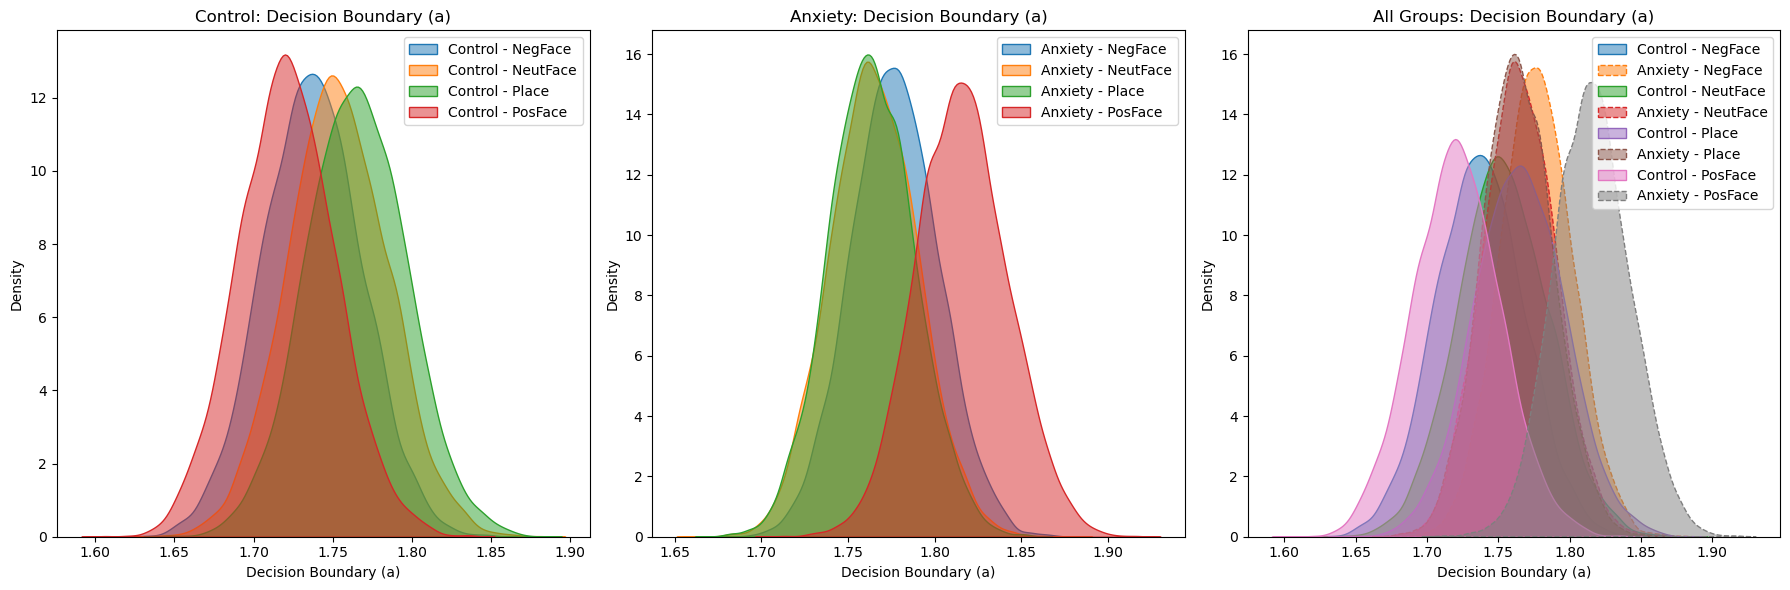

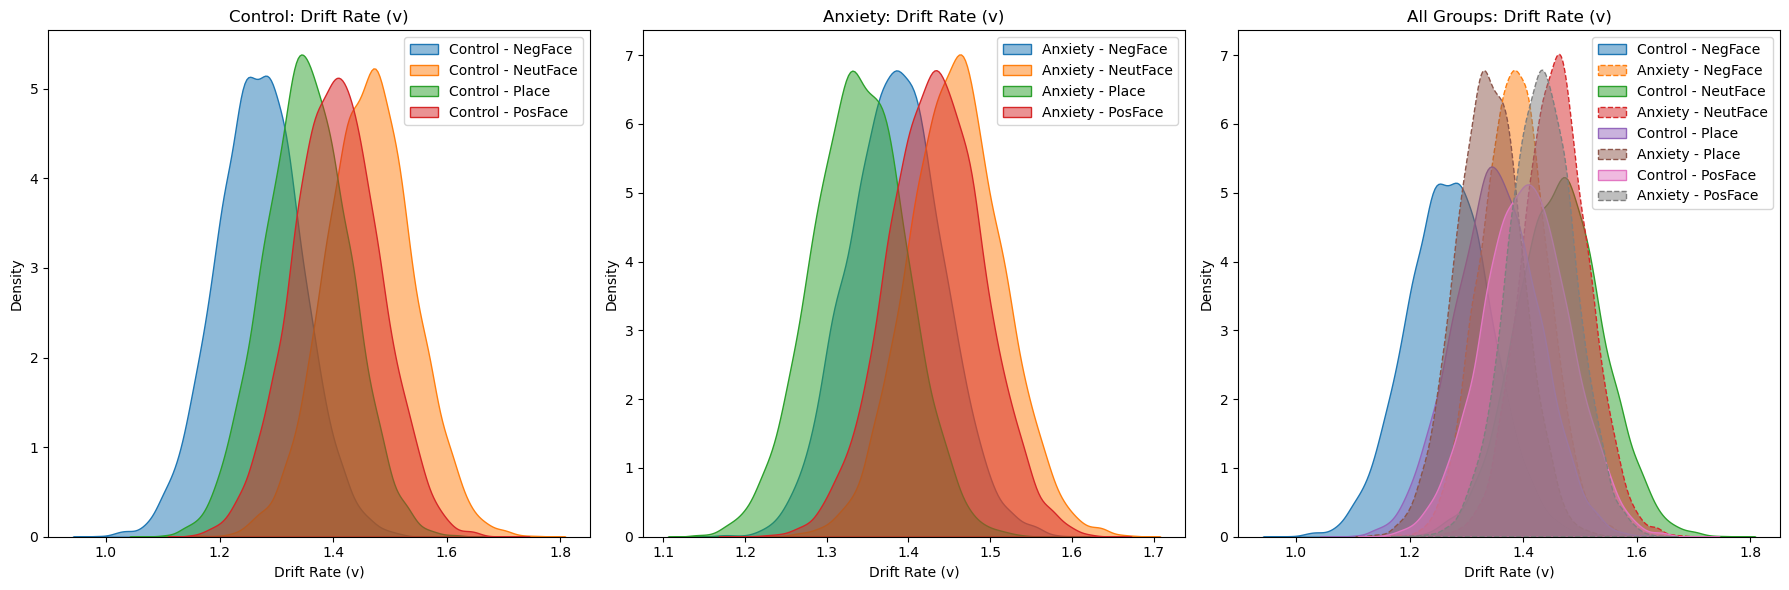

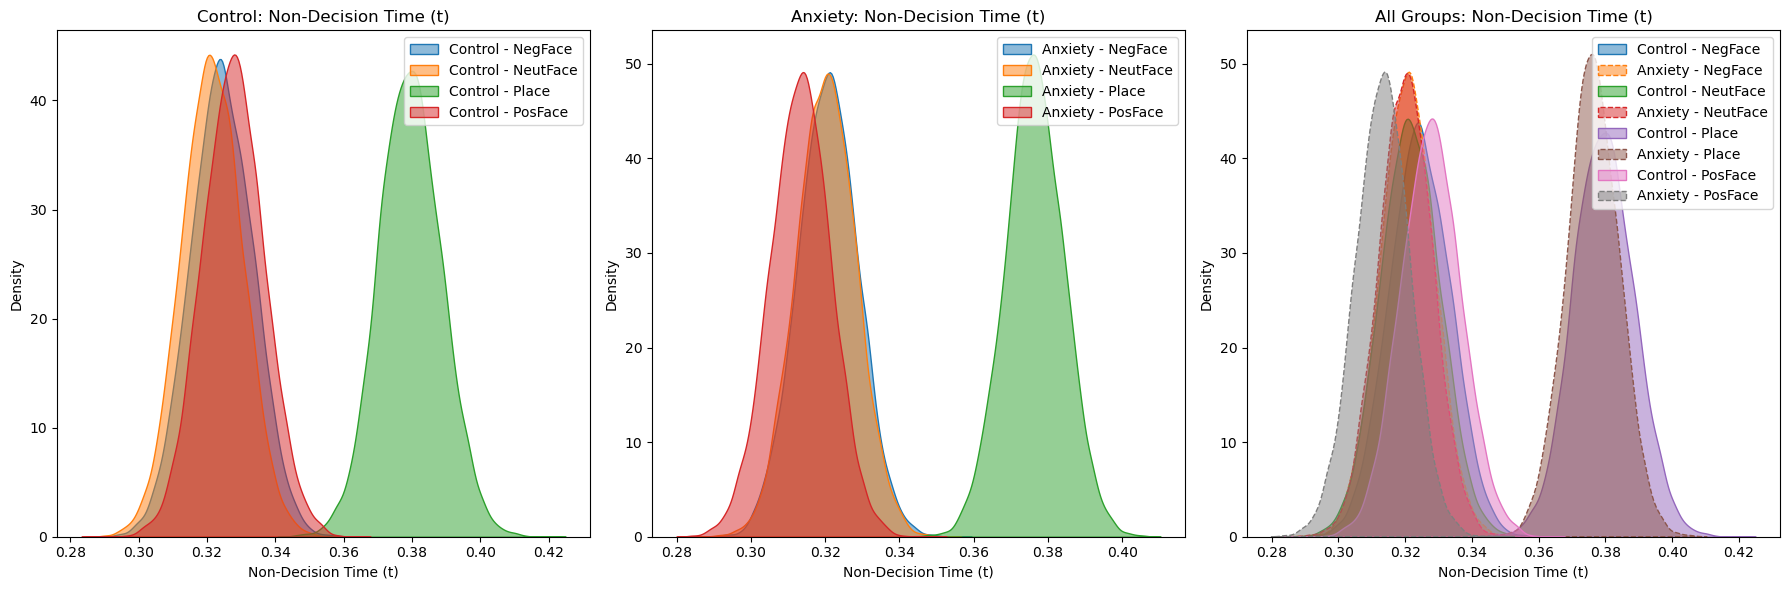

Probability results saved to 'model2_probability_results.csv'


In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv

# Ensure results list is initialized
results_for_csv = []

# Define model variable names
model_var_names = {"Control": "model2_anx0", "Anxiety": "model2_anx1"}

# Define parameters and their readable names
parameters = {
    'a': 'Decision Boundary (a)',
    'v': 'Drift Rate (v)',
    't': 'Non-Decision Time (t)'
}

# Define condition names
conditions = ["NegFace", "NeutFace", "Place", "PosFace"]

# Main processing loop for each parameter
for param_name in parameters:
    try:
        samples = {}  # Store samples for plotting

        # Load samples for Control and Anxiety across conditions
        for cond in conditions:
            control_key = model_var_names["Control"]
            anxiety_key = model_var_names["Anxiety"]

            samples[f"{cond}_0"] = get_param_samples(loaded_models[control_key]["infdata"], f"{param_name}({cond})")
            samples[f"{cond}_1"] = get_param_samples(loaded_models[anxiety_key]["infdata"], f"{param_name}({cond})")

        # Check for missing data
        if any(v is None for v in samples.values()):
            print(f"Missing parameter data for {param_name}, skipping.")
            continue

        # Compute Between-Group Probabilities (Anxiety vs. Control)
        probabilities = {
            cond: (samples[f"{cond}_1"] > samples[f"{cond}_0"]).mean()
            for cond in conditions
        }

        # Compute Bayes Factors and Interpretations for Between-Group
        bayes_factors = {
            cond: compute_bayes_factor(probabilities[cond])
            for cond in conditions
        }

        # Compute Within-Group Comparisons (Control & Anxiety separately)
        within_control_probs = {
            f"Control: P(PosFace > {cond})": (samples["PosFace_0"] > samples[f"{cond}_0"]).mean()
            for cond in ["NegFace", "NeutFace", "Place"]
        }
        within_control_probs.update({
            f"Control: P(NegFace > {cond})": (samples["NegFace_0"] > samples[f"{cond}_0"]).mean()
            for cond in ["NeutFace", "Place"]
        })
        within_control_probs["Control: P(NeutFace > Place)"] = (samples["NeutFace_0"] > samples["Place_0"]).mean()

        within_anxiety_probs = {
            f"Anxiety: P(PosFace > {cond})": (samples["PosFace_1"] > samples[f"{cond}_1"]).mean()
            for cond in ["NegFace", "NeutFace", "Place"]
        }
        within_anxiety_probs.update({
            f"Anxiety: P(NegFace > {cond})": (samples["NegFace_1"] > samples[f"{cond}_1"]).mean()
            for cond in ["NeutFace", "Place"]
        })
        within_anxiety_probs["Anxiety: P(NeutFace > Place)"] = (samples["NeutFace_1"] > samples["Place_1"]).mean()

        # **Append results for CSV (Between-Group Comparisons)**
        for cond in conditions:
            bf_10, bf_01, interpretation = bayes_factors[cond]
            results_for_csv.append({
                "Parameter": parameters[param_name],
                "Comparison": f"Anxiety vs. Control ({cond})",
                "P(Comparison)": round(probabilities[cond], 2),
                "Bayes Factor (BF10)": round(bf_10, 2),
                "Bayes Factor (BF01)": round(bf_01, 2),
                "Interpretation": interpretation
            })

        # **Append results for CSV (Within-Group Comparisons)**
        for key, value in within_control_probs.items():
            bf_10, bf_01, interpretation = compute_bayes_factor(value)
            results_for_csv.append({
                "Parameter": parameters[param_name],
                "Comparison": key,
                "P(Comparison)": round(value, 2),
                "Bayes Factor (BF10)": round(bf_10, 2),
                "Bayes Factor (BF01)": round(bf_01, 2),
                "Interpretation": interpretation
            })

        for key, value in within_anxiety_probs.items():
            bf_10, bf_01, interpretation = compute_bayes_factor(value)
            results_for_csv.append({
                "Parameter": parameters[param_name],
                "Comparison": key,
                "P(Comparison)": round(value, 2),
                "Bayes Factor (BF10)": round(bf_10, 2),
                "Bayes Factor (BF01)": round(bf_01, 2),
                "Interpretation": interpretation
            })

        # Create Three KDE Plots for Each Parameter
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Control Comparisons
        for cond in conditions:
            sns.kdeplot(samples[f"{cond}_0"], label=f"Control - {cond}", fill=True, alpha=0.5, ax=axes[0])
        axes[0].set_title(f"Control: {parameters[param_name]}")
        axes[0].set_xlabel(f"{parameters[param_name]}")
        axes[0].set_ylabel("Density")
        axes[0].legend()

        # Anxiety Comparisons
        for cond in conditions:
            sns.kdeplot(samples[f"{cond}_1"], label=f"Anxiety - {cond}", fill=True, alpha=0.5, ax=axes[1])
        axes[1].set_title(f"Anxiety: {parameters[param_name]}")
        axes[1].set_xlabel(f"{parameters[param_name]}")
        axes[1].set_ylabel("Density")
        axes[1].legend()

        # All Groups Combined
        for cond in conditions:
            sns.kdeplot(samples[f"{cond}_0"], label=f"Control - {cond}", fill=True, alpha=0.5, ax=axes[2])
            sns.kdeplot(samples[f"{cond}_1"], label=f"Anxiety - {cond}", fill=True, linestyle="dashed", alpha=0.5, ax=axes[2])
        axes[2].set_title(f"All Groups: {parameters[param_name]}")
        axes[2].set_xlabel(f"{parameters[param_name]}")
        axes[2].set_ylabel("Density")
        axes[2].legend()

        plt.tight_layout()
        plt.savefig(f"model2_{param_name}_posterior.pdf", bbox_inches='tight')
        plt.show()

    except KeyError:
        print(f"Missing parameter for {param_name}, skipping.")

# **Save results to a CSV file**
csv_filename = "model2_probability_results.csv"
with open(csv_filename, mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=["Parameter", "Comparison", "P(Comparison)", "Bayes Factor (BF10)", "Bayes Factor (BF01)", "Interpretation"])
    writer.writeheader()
    writer.writerows(results_for_csv)

print(f"Probability results saved to '{csv_filename}'")
